## Satish Agrawal
## Bellevue University
### DSC 550 Data mining - Original Case Study - Part I & 2

## Problem statement:

In the trucking industry, maintenance, breakdown, and safety are a few of the major concerns. There are preventive, routine maintenance to confirm the current state of equipment in the truck and avoid any breakdowns. And there are expenses after the breakdown (due to a missed routine maintenance) to get the truck back on the road. Unnecessary preventive checks cost money and add burden to the company, and on the other hand, a missed maintenance may cause a breakdown and cost the company even more. There is a need to predict the maintenance timeline to minimize both types of expenses.

## Proposal:         

There are many different parts in a truck that require maintenance. In this case study, we will focus on Air pressure system (APS). The APS generates pressurized air to be used in multiple functions of the truck operations while on the move. APS should be inspected routinely to confirm its quality and needed parts replacement. A missed checkup may cause even more to fix. The dataset for APS failure at Scania trucks (https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks) has 60000 observations of 171 attributes including “class”. The class can have one of the two possible values negative and positive. Negative represents the failure due to a non-APS component and Positive represents the component failure due to APS component failure. This is a supervised learning problem and I will map the negative class to 0 and positive to 1. All other columns are anonymized by the publisher due to copyrights and confidentiality. This should not be an issue for this project as we only predict and minimize the cost of failures with the combinations of these attributes. I will use the logistics regression model and the random forest classifiers.

 

Initial exploratory data analysis has revealed the class imbalance in the data set. There are more records for negative class and way too few for positive class. At this point in the analysis, I plan to use the area under the precision-recall curve. The scikit implementation of this is average precision. I chose this matric because it is stable under class imbalance.  

In [ ]:
!pip install pandas_profiling

In [2]:
import numpy as np
import pandas as pd
#import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklv

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.impute import SimpleImputer,MissingIndicator

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score,log_loss

%matplotlib inline

In [72]:
print('Using version %s of numpy' % np.__version__)
print('Using version %s of pandas' % pd.__version__)
print('Using version %s of seaborn' % sns.__version__)
print('Using version %s of sklearn' % sklv)
#print('Using version %s of pandas_profiling' % pp.__version__)

Using version 1.18.5 of numpy
Using version 1.0.5 of pandas
Using version 0.10.1 of seaborn
Using version 0.23.1 of sklearn


# Data set and EDA on dataset

In [123]:
# load the data from the file
data = pd.read_csv('final/aps_failure_training_set.csv')

In [124]:
# inspect the head
data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [125]:
# head did not tell number of records
len(data)

60000

In [126]:
# use shape to sum it up (num rows X num columns)
data.shape

(60000, 171)

In [127]:
# Replacing the na and nan values with np.NaN.
data.replace(to_replace='nan', value = np.NaN,inplace = True)

data.replace(to_replace='na', value = np.NaN,inplace = True)

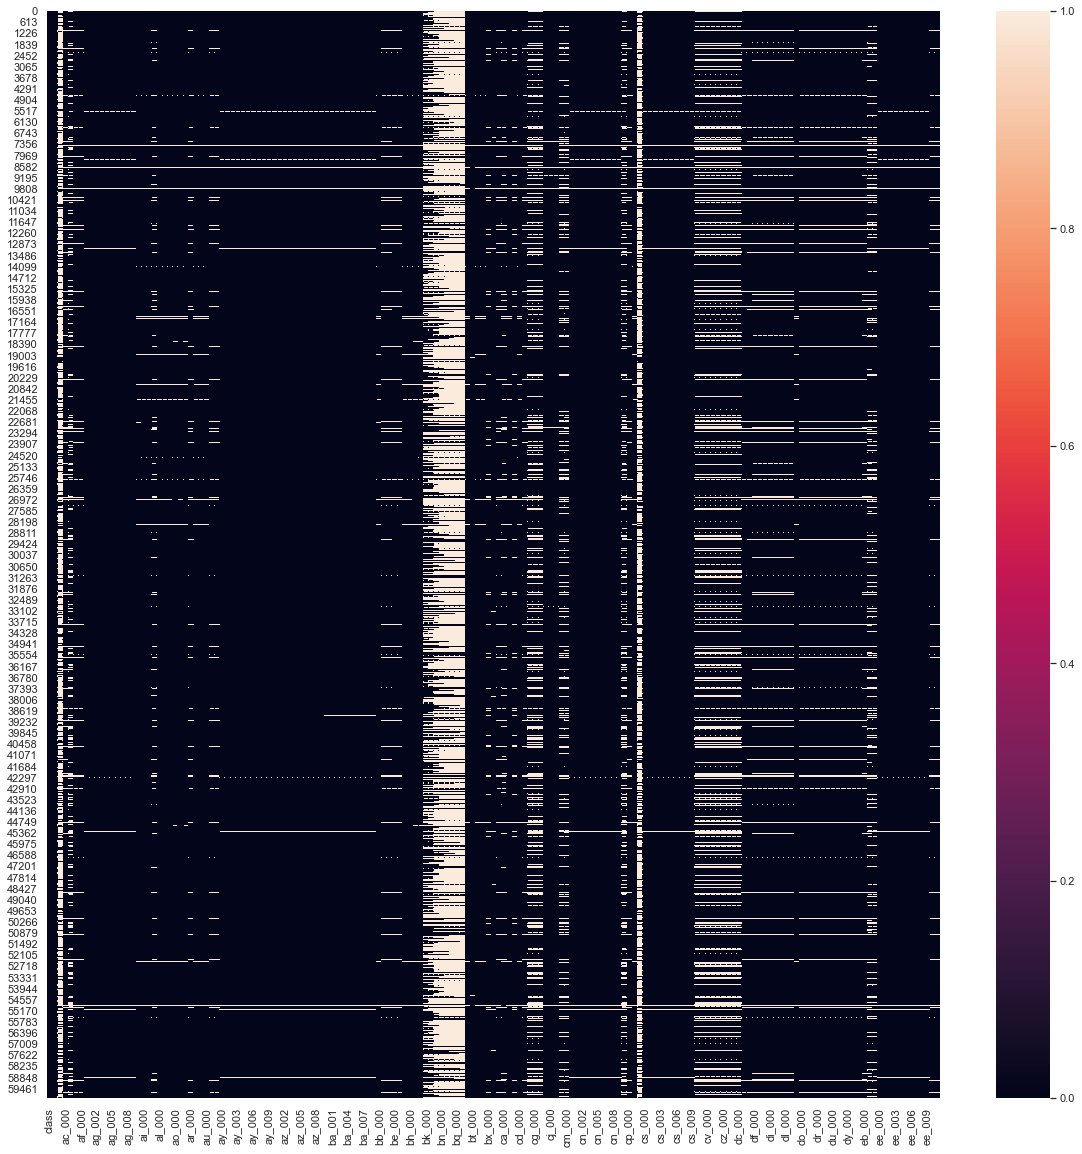

In [128]:
# plotting the heatmap of train dataset to visualize the null values.
sns.set(rc={'figure.figsize':(20,20)})
plot = sns.heatmap(data.isnull())
plt.show(plot)

A lot of missing data across the features. Dropping fetures with more than 70% of missing values

In [129]:
# Dropping all the columns where the number of missing values are more than 42K (more than 70% of missing values)
data.dropna(axis = 1, thresh=42000,inplace= True)

In [130]:
data.shape

(60000, 161)

In [131]:
# Replacing class labels to numeric values (0 : neg,1 : pos)
def binary_target(val):
    if (val == 'neg'):
        return 0
    else:
        return 1

In [132]:
# Distrubution of class labels in train dataset
data['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [133]:
data['class'] = data['class'].map(binary_target)

In [134]:
# varify if it worked
data['class'].value_counts()

0    59000
1     1000
Name: class, dtype: int64

In [135]:
# profile the data using pandas profiler
#pp.ProfileReport(data1).to_notebook_iframe()

In [136]:
data = data.apply(pd.to_numeric)

In [137]:
corr_matrix = data.corr()

In [138]:
corr_matrix["class"].sort_values(ascending=False)

class     1.000000
ci_000    0.553308
bb_000    0.542744
bv_000    0.541598
bu_000    0.541598
            ...   
da_000   -0.001800
dl_000   -0.002337
db_000   -0.012566
ac_000   -0.036533
cd_000         NaN
Name: class, Length: 161, dtype: float64

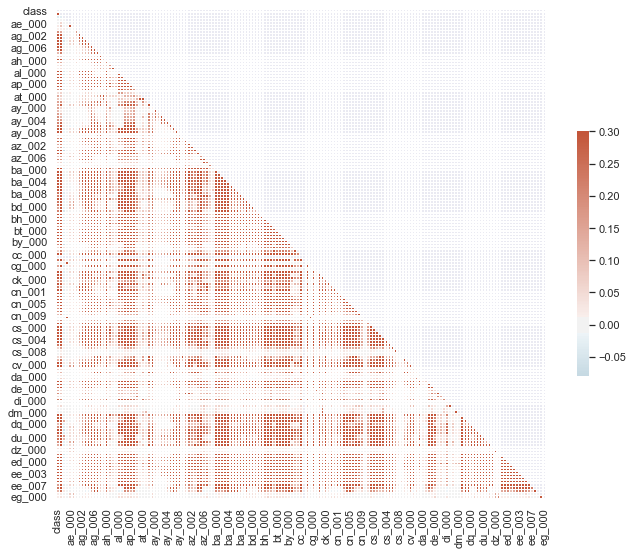

In [139]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

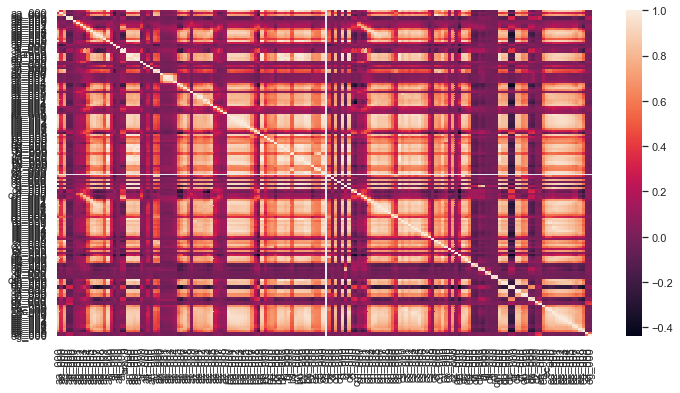

In [161]:
corelation_matrix = data.corr(method='spearman')
sns.heatmap(data = corelation_matrix,xticklabels=data.columns,yticklabels=data.columns)

Graph shows some correaltion between features itself. The strongest correaltion is at 0.30, which is considered to be a weak correlation. Looking at the class (target variable) it seems to have "more" correlation with some of features over others. 

In [140]:
# split out the target value from the data set and describe
data_target = data['class']
data.drop(['class'],axis = 1,inplace = True)

In [141]:
data.shape

(60000, 160)

In [142]:
# Describe the data set
print(data.describe())

             aa_000        ac_000        ad_000        ae_000        af_000  \
count  6.000000e+04  5.666500e+04  4.513900e+04  57500.000000  57500.000000   
mean   5.933650e+04  3.560143e+08  1.906206e+05      6.819130     11.006817   
std    1.454301e+05  7.948749e+08  4.040441e+07    161.543373    209.792592   
min    0.000000e+00  0.000000e+00  0.000000e+00      0.000000      0.000000   
25%    8.340000e+02  1.600000e+01  2.400000e+01      0.000000      0.000000   
50%    3.077600e+04  1.520000e+02  1.260000e+02      0.000000      0.000000   
75%    4.866800e+04  9.640000e+02  4.300000e+02      0.000000      0.000000   
max    2.746564e+06  2.130707e+09  8.584298e+09  21050.000000  20070.000000   

             ag_000        ag_001        ag_002        ag_003        ag_004  \
count  5.932900e+04  5.932900e+04  5.932900e+04  5.932900e+04  5.932900e+04   
mean   2.216364e+02  9.757223e+02  8.606015e+03  8.859128e+04  4.370966e+05   
std    2.047846e+04  3.420053e+04  1.503220e+05  7.

In [143]:
data.describe(include='all')

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,...,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,5.933650e+04,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,1.454301e+05,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,7.617312e+05,2.374282e+06,...,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.340000e+02,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.080000e+02,...,2.936000e+03,1.166000e+03,2.700000e+03,3.584000e+03,5.120000e+02,1.100000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.077600e+04,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.672000e+03,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,4.866800e+04,9.640000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.952200e+04,...,4.383960e+05,2.182320e+05,4.666140e+05,4.032220e+05,2.750940e+05,1.678140e+05,1.397240e+05,2.028000e+03,0.000000,0.000000
max,2.746564e+06,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,6.340207e+07,2.288306e+08,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


Text(0.5, 1.0, 'Histogram of class labels')

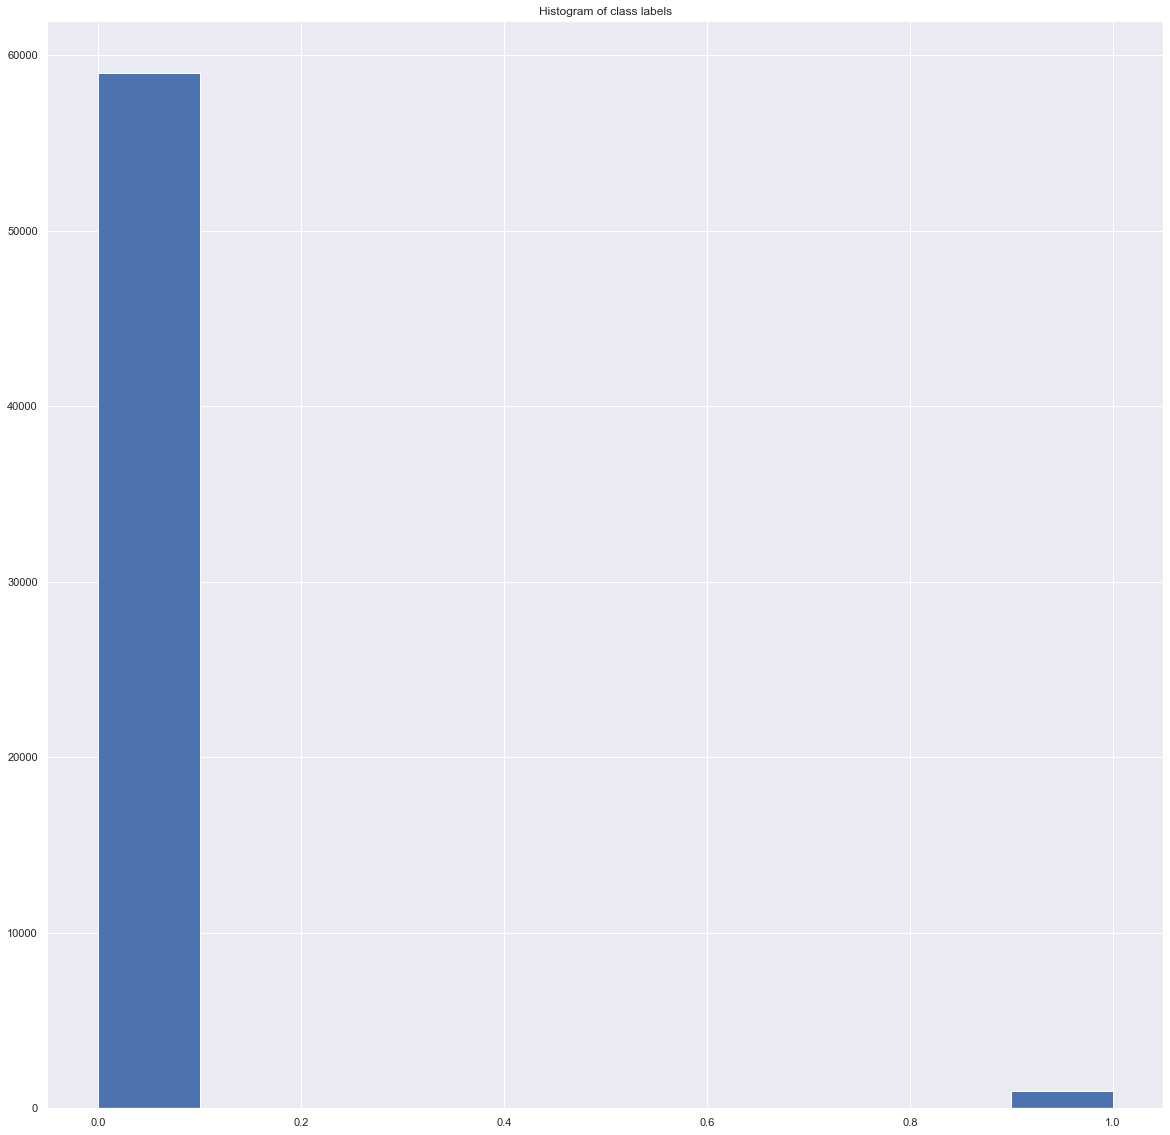

In [145]:
# Histogram plot of class labels of train dataset
plt.hist(data_target_bin)
plt.title("Histogram of class labels")

Histogram clearly shows the class imbalance. There are 59000 negative records versus only 1000 positive

# Test data

In [146]:
test = pd.read_csv('final/aps_failure_test_set.csv')

In [147]:
test_target = test['class']
test.drop(['class'],axis =1, inplace= True)

In [148]:
test_target_bin = test_target.map(binary_target)

In [149]:
# Standardizing the missing values in the test data set
test.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

# Imputing data

In [150]:
# Imputation using mean
impute_mean = SimpleImputer(missing_values= np.nan, strategy='mean',copy = True, verbose= 2)
data_imputed = pd.DataFrame(impute_mean.fit_transform(data),columns=data.columns)

In [151]:
data_imputed.describe()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,6.000000e+04,6.000000e+04,60000.000000,60000.000000,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,...,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,60000.000000,60000.000000
mean,5.933650e+04,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,1.454301e+05,7.724678e+08,3.504515e+07,158.142022,205.375337,2.036363e+04,3.400875e+04,1.494791e+05,7.574598e+05,2.360968e+06,...,1.149060e+06,5.402722e+05,1.161763e+06,1.114758e+06,1.063164e+06,1.718366e+06,4.469894e+05,4.720424e+04,4.268529,8.627929
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.340000e+02,2.000000e+01,4.200000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.180000e+02,...,3.033500e+03,1.204000e+03,2.848500e+03,3.839000e+03,5.600000e+02,1.180000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.077600e+04,1.880000e+02,2.880000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.881000e+03,...,2.397270e+05,1.148530e+05,2.283220e+05,1.960600e+05,9.976600e+04,4.358700e+04,4.474000e+03,0.000000e+00,0.000000,0.000000
75%,4.866800e+04,1.686000e+03,8.426500e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.361500e+04,...,4.454897e+05,2.164440e+05,4.624655e+05,4.003010e+05,2.833455e+05,1.732245e+05,1.387300e+05,2.366000e+03,0.000000,0.000000
max,2.746564e+06,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,6.340207e+07,2.288306e+08,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


In [152]:
# Imputation using median
impute_median = SimpleImputer(missing_values= np.nan, strategy='median',copy = True, verbose= 2)
data_imputed_median = pd.DataFrame(impute_median.fit_transform(data),columns=data.columns)

In [153]:
data_imputed_median.describe()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,6.000000e+04,6.000000e+04,60000.000000,60000.000000,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,...,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,60000.000000,60000.000000
mean,5.933650e+04,3.362258e+08,1.434383e+05,6.535000,10.548200,2.191577e+02,9.648104e+02,8.509771e+03,8.760054e+04,4.322495e+05,...,4.431223e+05,2.100188e+05,4.432268e+05,3.916653e+05,3.303672e+05,3.428586e+05,1.372212e+05,8.295099e+03,0.086467,0.203100
std,1.454301e+05,7.767625e+08,3.504525e+07,158.147893,205.387115,2.036364e+04,3.400891e+04,1.494818e+05,7.575171e+05,2.361408e+06,...,1.149276e+06,5.403725e+05,1.162002e+06,1.114964e+06,1.063465e+06,1.718666e+06,4.472145e+05,4.721249e+04,4.268570,8.628043
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.340000e+02,2.000000e+01,4.200000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.180000e+02,...,3.033500e+03,1.204000e+03,2.848500e+03,3.839000e+03,5.600000e+02,1.180000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.077600e+04,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.672000e+03,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,4.866800e+04,8.480000e+02,2.920000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.812400e+04,...,4.350315e+05,2.164440e+05,4.624655e+05,4.003010e+05,2.725220e+05,1.663465e+05,1.367255e+05,1.934000e+03,0.000000,0.000000
max,2.746564e+06,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,6.340207e+07,2.288306e+08,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


### Review

It was found that median imputation has better results. The other option was to use most frequent imputation which did not yield better results either.

#Imputation using most frequent
#impute_most_frequent = SimpleImputer(missing_values= np.nan, strategy='most_frequent',copy = True, verbose= 2)
#data_imputed_most_frequent = pd.DataFrame(impute_most_frequent.fit_transform(data),columns=data.columns)

In [154]:
# imputing the test data

# reducing down to the columns available in train data set
test = test[data.columns]

test_imputed = pd.DataFrame(impute_median.transform(test),columns=data.columns)

Test set has been imputed with median strategy. Ths data wil lbe utilized to measure the performance of the models later in the project

# Feature Engineering

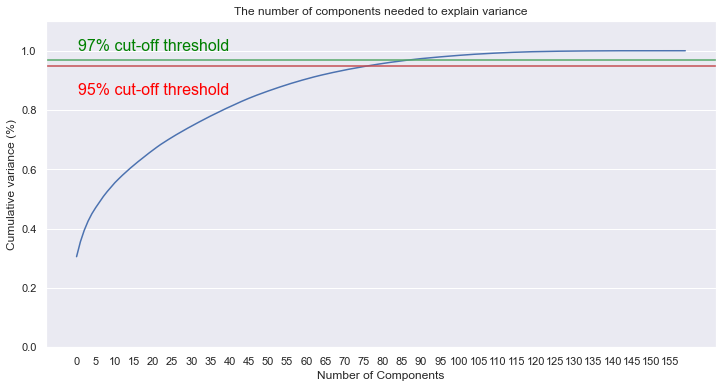

In [155]:
std = StandardScaler()
data_std = std.fit_transform(data_imputed_median)
pca = PCA().fit(data_std)


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(0, 160, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y,  linestyle='-', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 160, step=5)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.axhline(y=0.97, color='g', linestyle='-')
plt.text(0.5, 1.00, '97% cut-off threshold', color = 'green', fontsize=16)

ax.grid(axis='x')
plt.show()

### Review

In this graph, I am trying to see the correlation of features to the target variable. Originally dataset had 171 attributes which I reduced down to 161, as other attrbutes had too many missing values. As the plot depicts, 75 components can explain the 95% of the variance in the dataset and 85 components can exaplain the 97% of the variance. I plan to apply PCA with 99%.

In [156]:
pca = PCA(n_components= 0.99,whiten = True)
data_pca = pca.fit_transform(data_std)

In [157]:
print("original number of features:", data.shape[1])
print("reduced number of features:", data_pca.shape[1])

original number of features: 160
reduced number of features: 108


### Review

As I applied PCA with 99% variance I see that number of features have been reduced down to 108.

# Part 3 - Model evaluation and model selection

### Cost reduction

False negative and false positive are not same failure in prediction and should not be treated same. An extra maintenance trip without any failure (false positive) has less cost associated to it. As checking the equipment for failure costs less than fixing it. A missed maintenance trip (false negative) costs a lot more to replace parts and down time for the truck. 

https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks has a cost scheme to help calculate the cost and evaluate the model.

Cost-metric of miss-classification:

Cost_1 = 10 -- False Positive - Maintaenance without failure
Cost_2 = 500 -- False negative - Missed maintenance causing failure in APS

So total cost of misclassification would be (10 X FP) + (500 X FN)

In [63]:
# defining custom scorer to measure accuracy of the models. This scorer is an equation to reduce the maintenance cost.
from sklearn.metrics import make_scorer
from sklearn.metrics import SCORERS

def predicted_cost(test_target_bin, y_pred):
    cm =confusion_matrix(test_target_bin, y_pred)
    cost = (cm[0][1] * 10) + (cm[1][0] * 500)
    #print(cost)
    return cost

In [64]:
# Scorere needs to be added in the metrics list, to be used by GridSearchCV
SCORERS['my_scorer'] = make_scorer(predicted_cost, greater_is_better=False)

In [65]:
# Defining the LR model and performing the hyper parameter tuning using gridsearch
lr_clf = LogisticRegression(class_weight = 'balanced',n_jobs= -1,
                            random_state=42)

params = {'C' : [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3],
          'penalty': ['l1', 'l2']
         }

lr_clf.fit(data_pca,data_target_bin)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)

In [66]:
# using my_scorer to validate the performance
# using 5 fold cross validation
lr_grid = GridSearchCV(estimator=lr_clf,
                     cv = 5,
                     n_jobs= -1,
                     param_grid=params,
                     scoring='my_scorer',
                     verbose= 2,)

In [67]:
lr_grid.fit(data_pca,data_target_bin)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.6s finished


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='my_scorer', verbose=2)

In [54]:
print("Best estimator is", lr_grid.best_params_)

Best estimator is {'C': 0.001, 'penalty': 'l2'}


In [55]:
pd.DataFrame(lr_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.089200,0.001166,0.000000,0.000000,0.0001,l1,"{'C': 0.0001, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
1,0.789600,0.069351,0.020802,0.001167,0.0001,l2,"{'C': 0.0001, 'penalty': 'l2'}",-15210.0,-15510.0,-19240.0,-11660.0,-16210.0,-15566.0,2420.732121,8
2,0.092000,0.002756,0.000000,0.000000,0.001,l1,"{'C': 0.001, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
3,0.956400,0.216902,0.020201,0.000980,0.001,l2,"{'C': 0.001, 'penalty': 'l2'}",-10790.0,-12570.0,-15180.0,-8380.0,-12760.0,-11936.0,2261.102386,1
4,0.142400,0.015461,0.000000,0.000000,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
5,2.416800,0.090288,0.022601,0.000799,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",-9860.0,-14170.0,-14820.0,-10480.0,-12540.0,-12374.0,1956.707439,6
6,0.124199,0.003544,0.000000,0.000000,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
7,3.544398,0.045178,0.020003,0.001265,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",-9820.0,-12630.0,-15320.0,-10480.0,-12560.0,-12162.0,1932.070392,2
8,0.141000,0.014283,0.000000,0.000000,1,l1,"{'C': 1, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
9,3.659200,0.056408,0.019801,0.001470,1,l2,"{'C': 1, 'penalty': 'l2'}",-10340.0,-12620.0,-15280.0,-10460.0,-13090.0,-12358.0,1833.972737,4


In [46]:
pd.DataFrame(lr_grid.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(5)

,params,mean_test_score
3,"{'C': 0.001, 'penalty': 'l2'}",-11936.0
7,"{'C': 0.1, 'penalty': 'l2'}",-12162.0
11,"{'C': 10, 'penalty': 'l2'}",-12352.0
9,"{'C': 1, 'penalty': 'l2'}",-12358.0
13,"{'C': 100, 'penalty': 'l2'}",-12370.0


In [68]:
# model fitting and hyperparamter tunning
rf_cfl=RandomForestClassifier()

prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10] 
    }

# using my_scorer to validate performance
# using 5 flod cross valiation
rf_grid=GridSearchCV(rf_cfl,
                     param_grid=prams,
                     verbose=10,
                     n_jobs=-1,
                     scoring='my_scorer',
                     cv=5)

In [69]:
rf_grid.fit(data_pca,data_target_bin)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed: 21.6min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 31.5min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 39.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200, 500, 1000, 2000]},
             scoring='my_scorer', verbose=10)

In [74]:
print("Best estimator is", rf_grid.best_params_)

Best estimator is {'max_depth': 10, 'n_estimators': 200}


In [75]:
pd.DataFrame(rf_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.989405,0.115168,0.162599,0.019159,3,100,"{'max_depth': 3, 'n_estimators': 100}",-93000.0,-93500.0,-91500.0,-88500.0,-91010.0,-91502.0,1760.118178,11
1,38.849008,0.525861,0.282999,0.012264,3,200,"{'max_depth': 3, 'n_estimators': 200}",-91500.0,-95500.0,-92000.0,-89000.0,-92500.0,-92100.0,2083.266666,12
2,104.574250,1.351419,0.747801,0.034184,3,500,"{'max_depth': 3, 'n_estimators': 500}",-92500.0,-95000.0,-92500.0,-90500.0,-93500.0,-92800.0,1469.693846,13
3,220.408187,2.344281,1.458401,0.011943,3,1000,"{'max_depth': 3, 'n_estimators': 1000}",-92500.0,-96500.0,-93000.0,-90510.0,-93500.0,-93202.0,1936.289235,15
4,464.305316,4.207496,2.906201,0.022355,3,2000,"{'max_depth': 3, 'n_estimators': 2000}",-92500.0,-95500.0,-92500.0,-90510.0,-93500.0,-92902.0,1621.855727,14
5,37.043310,0.442583,0.179600,0.012689,5,100,"{'max_depth': 5, 'n_estimators': 100}",-69090.0,-70530.0,-68570.0,-66050.0,-69090.0,-68666.0,1461.965800,6
6,76.449923,0.465828,0.327200,0.005493,5,200,"{'max_depth': 5, 'n_estimators': 200}",-70550.0,-69550.0,-67600.0,-65090.0,-73050.0,-69168.0,2691.262901,10
7,193.261906,1.144918,0.778201,0.020004,5,500,"{'max_depth': 5, 'n_estimators': 500}",-71060.0,-69550.0,-66590.0,-64580.0,-71560.0,-68668.0,2679.293937,7
8,390.280756,1.787188,1.601400,0.073568,5,1000,"{'max_depth': 5, 'n_estimators': 1000}",-69060.0,-71560.0,-66570.0,-65050.0,-73560.0,-69160.0,3121.864827,9
9,792.454036,2.830144,3.129434,0.104451,5,2000,"{'max_depth': 5, 'n_estimators': 2000}",-70560.0,-70560.0,-66570.0,-65570.0,-72060.0,-69064.0,2525.079009,8


In [76]:
pd.DataFrame(rf_grid.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score']].head(10)

,params,mean_test_score
11,"{'max_depth': 10, 'n_estimators': 200}",-46368.0
14,"{'max_depth': 10, 'n_estimators': 2000}",-46666.0
13,"{'max_depth': 10, 'n_estimators': 1000}",-46766.0
12,"{'max_depth': 10, 'n_estimators': 500}",-47366.0
10,"{'max_depth': 10, 'n_estimators': 100}",-47552.0
5,"{'max_depth': 5, 'n_estimators': 100}",-68666.0
7,"{'max_depth': 5, 'n_estimators': 500}",-68668.0
9,"{'max_depth': 5, 'n_estimators': 2000}",-69064.0
8,"{'max_depth': 5, 'n_estimators': 1000}",-69160.0
6,"{'max_depth': 5, 'n_estimators': 200}",-69168.0


In [77]:
def print_confusionmatrix(cm):
    print('Confusion Matrix: ', '\n',cm)
    print("-"*50)
    print("Cost 1 (FP) = ", cm[1][0])
    print("Cost 2 (FN) = ", cm[0][1])
    print("Total cost = ", cm[0][1] * 10 + cm[1][0] * 500)

In [79]:
# logistics regressor fitting using the best parameter.
lr_clf = LogisticRegression(n_jobs= -1,random_state=42,C= 0.001,penalty= 'l2')
lr_clf.fit(data_imputed_median,data_target_bin)

# Use test data to get predicted cost
y_pred = lr_clf.predict(test_imputed)
cm_lr =confusion_matrix (test_target_bin, y_pred)

print_confusionmatrix(cm_lr)

Confusion Matrix:  
 [[15566    59]
 [  151   224]]
--------------------------------------------------
Cost 1 (FP) =  151
Cost 2 (FN) =  59
Total cost =  76090


In [80]:
# Random forest classifier using the best parameter 
rf_clf = RandomForestClassifier(n_estimators= 200 , max_depth=10,n_jobs= -1)
rf_clf.fit(data_imputed_median,data_target_bin)

# use test data to get predicted cost
y_pred = rf_clf.predict(test_imputed)
cm_rf =confusion_matrix (test_target_bin, y_pred)

print_confusionmatrix(cm_rf)

Confusion Matrix:  
 [[15609    16]
 [  126   249]]
--------------------------------------------------
Cost 1 (FP) =  126
Cost 2 (FN) =  16
Total cost =  63160


## Conclusion

It is evident from the total cost of missed classification is much lower with random forest classifier versus logistics regression. Best hyperparameters are n_estimators = 200 and max_depth = 10. Random forest works better because it is simply a collection of decision trees with result aggregated in one final result. It has the ability to  limit overfitting increasing error. The next step would be to try CatBoost classifiers and see if it performs better in terms of reducing the total cost. 

Another important factor of this result is imputation. I tried three strategies, mean, median and most_frequent. I ended up choosing median as it had the best cost. We should check other imputations like KNN imputation, hot deck, cold deck and others to see if it helps reduce the final cost.